# Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

Matplotlib created a temporary cache directory at /tmp/matplotlib-bkcjtmos because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Utils

In [3]:
def print_tensor_stats(tensor, name):
    print(f"{name}: min={tensor.min().item()}, max={tensor.max().item()}, mean={tensor.mean().item()}, std={tensor.std().item()}")

In [15]:
from datasets import show_images

## English handwritten characters

In [126]:
class EhcDataset(Dataset):
    def __init__(self, path, transform=None, limit=None):
        self.path = path
        self.transform = transform 
        self.dataset = pd.read_csv(f"{path}/english.csv")
        self.mapping = lambda label: ord(label) - 48
        self.unmapping = lambda label: chr(label + 48)
        if limit:
            self.dataset = self.dataset.sample(n=limit)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            images_path = self.dataset.iloc[idx]["image"]
            images = [Image.open(f"{self.path}/{path}") for path in images_path]
            if self.transform:
                images = torch.stack([self.transform(img) for img in images])  # Apply transform per image
                images = images.unsqueeze(1)  # Add channel dimension: [Batch, 1, 28, 28]

            labels = list(map(self.mapping, self.dataset.iloc[idx]["label"]))
            labels = torch.tensor(labels, dtype=torch.long)
            return images, labels

        else:
            image_path = self.dataset.iloc[idx]["image"]
            image = Image.open(f"{self.path}/{image_path}")
            if self.transform:
                image = self.transform(image)
                # image = image.unsqueeze(0) 
                # print_tensor_stats(image, "Transformed Image")

            label = self.mapping(self.dataset.iloc[idx]["label"])
            label = torch.tensor(label, dtype=torch.long)
            return image, label

In [118]:
ehc_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Lambda(lambda image: 1 - image),  # Invert the image
        transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize to [-1, 1]
        transforms.CenterCrop((900, 900)),
        transforms.Resize((28, 28))
    ])

In [129]:
def show_ehc_images(images, num_rows=1, title=None, unmapping=None):
    """
    Display a set of images in a grid.
    """
    num_images = len(images[0])
    num_cols = np.ceil(num_images / num_rows)  # Calculate number of columns

    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(num_rows, int(num_cols), figsize=(2 * num_cols, 2 * num_rows))
    
    if title:
        plt.suptitle(title)  # Set the title for the entire figure

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Display image
            ax.imshow(images[0][i][0].numpy().transpose(1, 2, 0), cmap='gray')
            ax.set_title(unmapping(images[1][i].item()))
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide axes for empty subplots

    plt.tight_layout()
    plt.show()


In [127]:
ehc_dataset = EhcDataset("data/english_handwritten_characters", ehc_transform, limit=128)
ehc_dataset[0][0].shape

torch.Size([1, 28, 28])

16


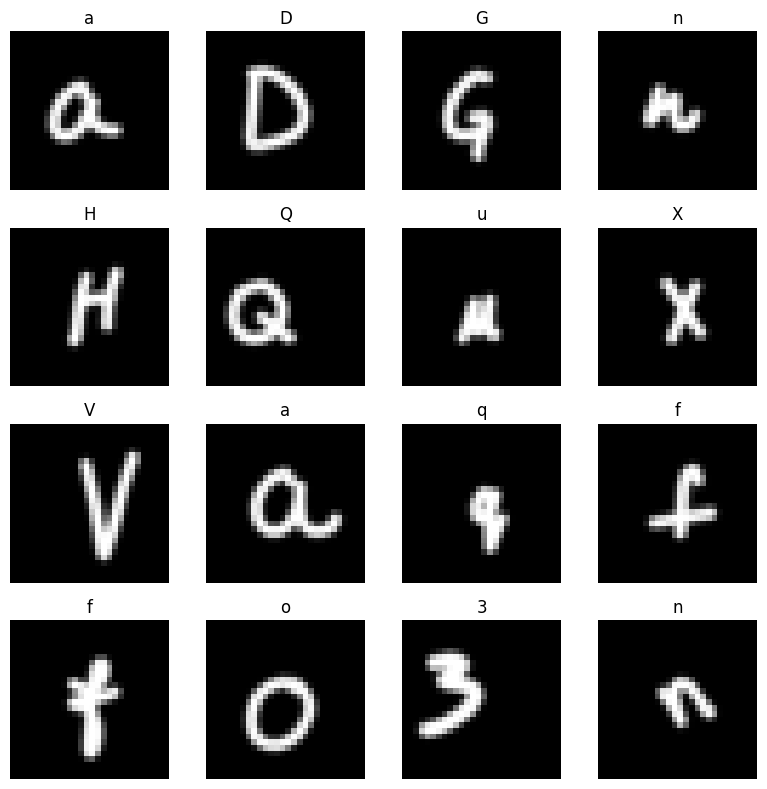

In [128]:
show_ehc_images(ehc_dataset[:16], 4, unmapping=ehc_dataset.unmapping)

## EMNIST

In [121]:
from datasets import EmnistDataset, EmnistMapping, emnist_transform

In [3]:
class EmnistDataset(Dataset):
    def __init__(self, path, transform=None, limit=None):
        self.path = path
        self.transform = transform 
        dataset = pd.read_csv(path, header=None)
        if limit:
            dataset = dataset.sample(n=limit)
        X, y = dataset[list(range(1, dataset.shape[1]))], dataset[0]
        self.X = X.to_numpy().reshape((-1, 28, 28))
        self.y = y.to_numpy()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            # Handle slicing
            images = torch.tensor(self.X[idx], dtype=torch.float32)
            images = images.unsqueeze(1)  # Add channel dimension: [Batch, 1, 28, 28]
            labels = torch.tensor(self.y[idx], dtype=torch.long)
            if self.transform:
                images = torch.stack([self.transform(img / 255.0) for img in images])  # Apply transform per image
            return images, labels
        else:
            # Handle single item
            image = torch.tensor(self.X[idx], dtype=torch.float32)
            image = image.unsqueeze(0)  # Channel dimension: [1, 28, 28]
            if self.transform:
                image /= 255.0
                image = self.transform(image)
            label = torch.tensor(self.y[idx], dtype=torch.long)
            return image, label

class EmnistMapping:
    def __init__(self, path):
        with open(path, "r") as f:
            lines = f.read().split("\n")[:-1]
            class_to_char = {}
            for line in lines:
                char_class, char_code = line.split()
                class_to_char[int(char_class)] = chr(int(char_code))
        self.class_to_char = class_to_char

    def __getitem__(self, key):
        return self.class_to_char[key]

    def __str__(self):
        return str(self.class_to_char)

In [4]:
emnist_transform = transforms.Compose([
        transforms.RandomRotation((-90, -90)),          # Rotate by exactly 90 degrees
        transforms.RandomHorizontalFlip(p=1),
        transforms.Normalize((0.5,), (0.5,))  # Normalizes tensor to have mean around 0 and variance around 1
    ])

In [6]:
def show_emnist_images(images, num_rows=1, mapping=None, title=None):
    """
    Display a set of images in a grid.
    
    Parameters:
        images (list or ndarray): torch tensor on dim (2, n, 1, 28, 28)
        num_rows (int): Number of rows in the image grid.
        title (str): Optional title for the overall figure.
    """
    num_images = len(images[0])
    print(num_images)
    num_cols = np.ceil(num_images / num_rows)  # Calculate number of columns

    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(num_rows, int(num_cols), figsize=(2 * num_cols, 2 * num_rows))
    
    if title:
        plt.suptitle(title)  # Set the title for the entire figure

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Display image
            ax.imshow(images[0][i][0].numpy(), cmap='gray')
            ax.set_title(mapping[images[1][i].item()])
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide axes for empty subplots

    plt.tight_layout()
    plt.show()


In [7]:
emnist_dataset = EmnistDataset("data/emnist/emnist-balanced-test.csv", emnist_transform, limit=128)
emnist_mapping = EmnistMapping("data/emnist/emnist-balanced-mapping.txt")
emnist_dataset[0][0].shape

torch.Size([1, 28, 28])

16


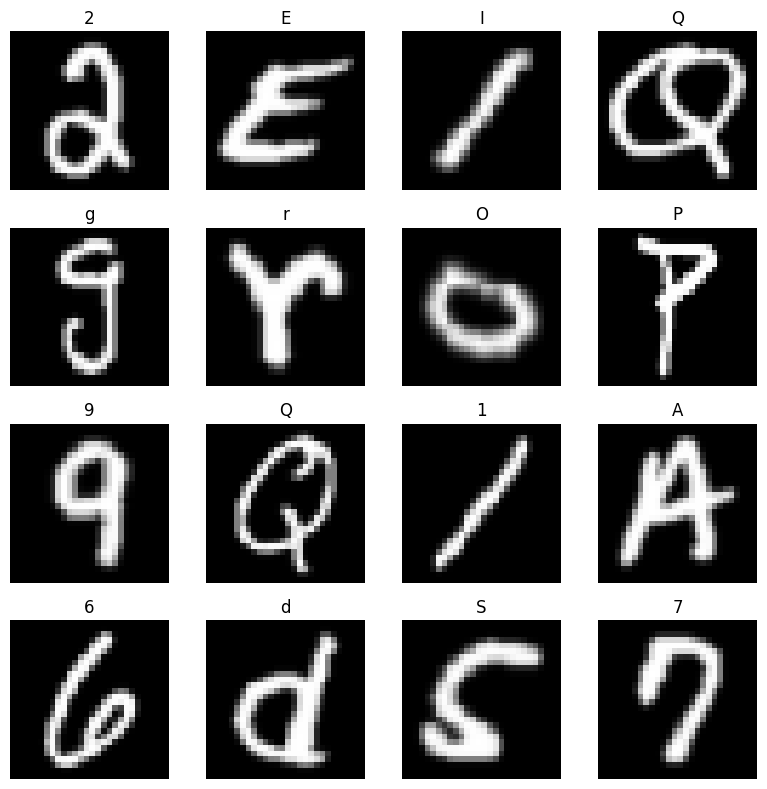

In [8]:
show_emnist_images(emnist_dataset[:16], 4, mapping=emnist_mapping)

## CHoiCe

In [136]:
import os

In [198]:
class ChoicetDataset(Dataset):
    def __init__(self, path, transform=None, limit=None):
        self.path = path
        self.transform = transform
        self.dataset = pd.DataFrame(columns=["path", "label"])
        for dir in os.listdir(path + "/data"):
            new_rows = {"path": os.listdir(path + "/data/" + dir), "label": len(os.listdir(path + "/data/" + dir)) * [dir]}
            new_dataset = pd.DataFrame(new_rows)
            self.dataset = pd.concat([self.dataset, new_dataset], ignore_index=True)
        if limit:
            self.dataset = self.dataset.sample(limit)
        with open(path + "/label.txt", "r") as f:
            lines = f.read().split("\n")
            self.mapping = {idx: char for idx, char in enumerate(lines)}
            self.unmapping = {char: idx for idx, char in enumerate(lines)}

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            images_path = list(self.dataset.iloc[idx]['path'])
            labels = list(self.dataset.iloc[idx]['label'].astype(int))
            images = [Image.open(f"{self.path}/data/{labels[i]}/{images_path[i]}") for i in range(len(labels))]
            if self.transform:
                images = torch.stack([self.transform(image) for image in images])
                # images = images.unsqueeze(1)
            labels = torch.tensor(labels, dtype=torch.long)
            return images, labels
        else:
            image_path = self.dataset.iloc[idx]['path']
            label = self.dataset.iloc[idx]['label']
            image = Image.open(f"{self.path}/data/{label}/{image_path}")
            if self.transform:
                image = self.transform(image)
            label = torch.tensor(int(label), dtype=torch.long)
            return image, label


In [219]:
choice_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda image: 1 - image),  # Invert the image
        transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize to [-1, 1]
    ])

In [220]:
choice_dataset = ChoicetDataset("/teamspace/studios/this_studio/data/choice", choice_transform, limit=128)

In [200]:
choice_dataset[0][0].shape

torch.Size([1, 28, 28])

In [201]:
x = choice_dataset[:2]
x[0][0].shape

torch.Size([1, 28, 28])

In [216]:
def show_choice_images(images, num_rows=1, title=None, mapping=None):
    """
    Display a set of images in a grid.
    """
    num_images = len(images[0])
    num_cols = np.ceil(num_images / num_rows)  # Calculate number of columns

    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(num_rows, int(num_cols), figsize=(2 * num_cols, 2 * num_rows))
    
    if title:
        plt.suptitle(title)  # Set the title for the entire figure

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Display image
            ax.imshow(images[0][i].numpy().transpose(1, 2, 0), cmap='gray')
            ax.set_title(mapping[images[1][i].item()])
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide axes for empty subplots

    plt.tight_layout()
    plt.show()


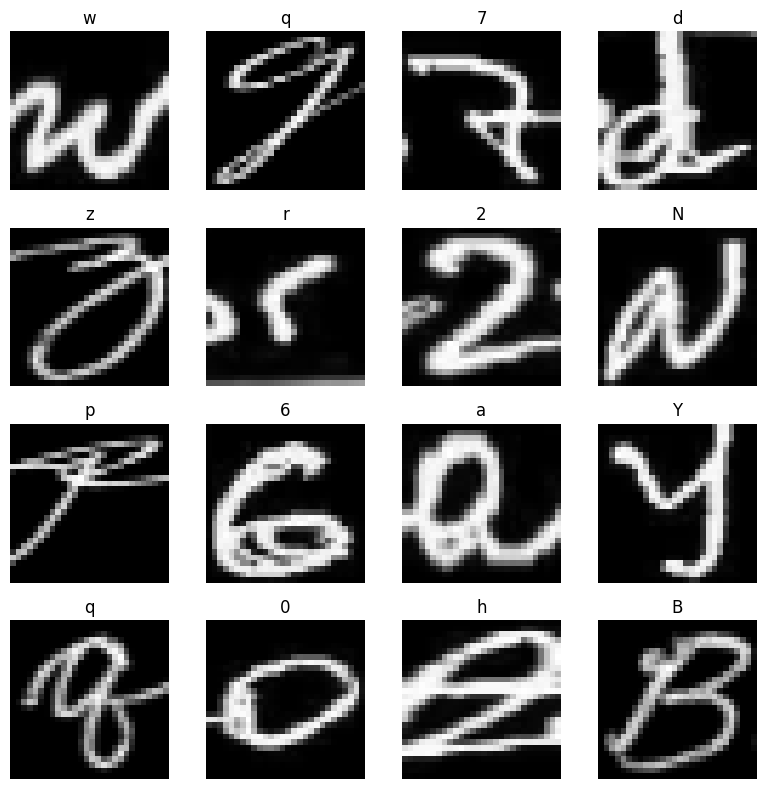

In [221]:
show_choice_images(choice_dataset[:16], 4, mapping=choice_dataset.mapping)

## GAN

In [8]:
class GanDataset:
    def __init__(self, dataset_path, mapping_path, transform=None, limit=None):
        self.path = dataset_path
        self.dataset = pd.read_csv(self.path)
        self.transform = transform
        with open(mapping_path, "r") as f:
            lines = f.read().split("\n")[:-1]
            self.mapping = {}
            self.unmapping = {}
            for line in lines:
                char_class, char_code = line.split()
                self.mapping[int(char_class)] = chr(int(char_code))
                self.unmapping[chr(int(char_code))] = int(char_class)
        if limit:
            self.dataset = self.dataset.sample(limit)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            images_path = self.dataset.iloc[idx]["path"]
            images = [Image.open(path) for path in images_path]
            if self.transform:
                images = torch.stack([self.transform(img) for img in images])  # Apply transform per image
                # images = images.unsqueeze(1)  # Add channel dimension: [Batch, 1, 28, 28]

            labels = [self.unmapping[label] for label in self.dataset.iloc[idx]["label"]]
            labels = torch.tensor(labels, dtype=torch.long)
            return images, labels

        else:
            image_path = self.dataset.iloc[idx]["path"]
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
                # image = image.unsqueeze(0) 
                # print_tensor_stats(image, "Transformed Image")

            label = self.unmapping[self.dataset.iloc[idx]["label"]]
            label = torch.tensor(label, dtype=torch.long)
            return image, label


gan_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize to [-1, 1]
    ])

In [5]:
from config import GAN_DATASET_PATH, GAN_MAPPING_PATH

In [12]:
gan_dataset = GanDataset(GAN_DATASET_PATH, GAN_MAPPING_PATH, transform=gan_transform, limit=128)
print("Shape:", gan_dataset[0][0].size())
print_tensor_stats(gan_dataset[0][0], "GAN")

Shape: torch.Size([1, 28, 28])
GAN: min=-1.0, max=0.9998000860214233, mean=-0.7227368354797363, std=0.5540255308151245


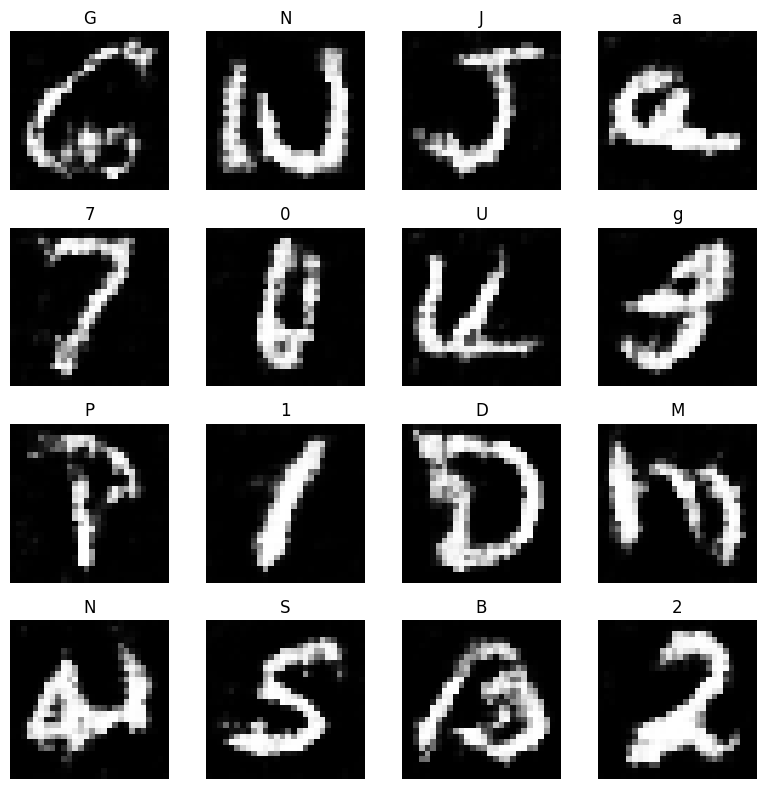

In [13]:
show_images(gan_dataset[:16], 4, gan_dataset.mapping)